# Project 2. P2P  대출심사 알고리듬
**과목명:  응용데이터애널리틱스 (Applied Data Analytics)** \\
**학수번호:  INE4108** \\
**교강사:  송재욱 교수 (산업공학과)** \\
 \\
***

## 1. Environmental Set-up & Data Loading

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Google Drive where you have saved the unzipped
FOLDERNAME =  'ADX/'

assert FOLDERNAME is not None, 'ERROR'

%cd drive/My\ Drive
%cp -r $FOLDERNAME ../../

Mounted at /content/drive
/content/drive/My Drive


In [ ]:
# 모델 수립을 위한 Train/Validation Set
df = pd.read_csv('/content/drive/MyDrive/ADX/P2_dataset.csv', encoding ='cp949')

# 시스템 구현을 위한 Test Set 샘플
df_test = pd.read_csv('/content/drive/MyDrive/ADX/P2_dataset_test_sample.csv', encoding ='cp949')

delete_col = ['funded_amnt', 'funded_amnt_inv', 'installment', 'grade', 'open_acc', 'initial_list_status', 'recoveries',
              'collection_recovery_fee', 'acc_now_delinq', 'delinq_amnt', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',	'total_rec_int',	'total_rec_late_fee', 'last_pymnt_amnt']
df_1 = df.copy()
df_1 = df_1.drop(columns=delete_col)

# Train 결측치처리

In [ ]:
df_1['collections_12_mths_ex_med']=df_1['collections_12_mths_ex_med'].replace(np.nan, df_1['collections_12_mths_ex_med'].median())
df_1['chargeoff_within_12_mths']=df_1['chargeoff_within_12_mths'].replace( np.nan, df_1['chargeoff_within_12_mths'].median())
df_1['pub_rec_bankruptcies']=df_1['pub_rec_bankruptcies'].replace(np.nan, df_1['pub_rec_bankruptcies'].median())
df_1['tax_liens']=df_1['tax_liens'].replace(np.nan, df_1['tax_liens'].median())
df_1['revol_util']=df_1['revol_util'].replace(np.nan, df_1['revol_util'].median())
# NaN 값을 '10+ years'로 대체
df_1['emp_length'].fillna('10+ years', inplace=True)

# Train 이상치제거

In [ ]:
df_2=df_1.copy()
df_2 = df_2[df_2['revol_util'] <= 1.00]
df_2 = df_2[df_2['home_ownership'].isin(['MORTGAGE', 'OTHER', 'OWN', 'RENT'])]

# Train 범주형인코딩

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

df_3 = df_2.copy()
df_3.reset_index(drop=True, inplace=True)
selected_list=['emp_length', 'verification_status']

label_encoders = {}
for column in selected_list:
    le = LabelEncoder()
    df_3[column] = le.fit_transform(df_3[column])
    label_encoders[column] = le

In [ ]:
purpose_order = ['car', 'major_purchase', 'credit_card', 'wedding', 'home_improvement',
       'debt_consolidation', 'house', 'vacation', 'other', 'educational',
       'medical', 'renewable_energy', 'moving', 'small_business']
encoder_1 = OrdinalEncoder(categories=[purpose_order])
df_3['purpose'] = encoder_1.fit_transform(df_3[['purpose']])

home_order = ['OTHER', 'RENT', 'OWN', 'MORTGAGE']
home_order = home_order[::-1]
encoder_2 = OrdinalEncoder(categories=[home_order])
df_3['home_ownership'] = encoder_2.fit_transform(df_3[['home_ownership']])

sg_order = sorted(df_3['sub_grade'].unique())
encoder_3 = OrdinalEncoder(categories = [sg_order])
df_3['sub_grade'] = encoder_3.fit_transform(df_3[['sub_grade']])

mapping = {
    "Fully Paid": -1.0,
    "Charged Off": 1.0
}

# 매핑 적용
df_3['loan_status'] = df_3['loan_status'].map(mapping)

In [ ]:
continuous_list=[p for p in df_3.columns if p not in ['emp_length', 'verification_status', 'loan_status', 'purpose', 'home_ownership', 'sub_grade']]

## 2. Modelling
- df를 사용하여 예측모형 수립
- Feature engineering에 대한 토의/구현 진행
- Computation time을 고려하여 전체 데이터를 완전히 사용하지 말고 Sampling하여 Model Train/Vadliation을 진행하는 것을 추천
- Sampling을 단 한번 한 것으로 모형 Train 한 것이 과연 옳은 것인지에 대해 팀원들과 고민해볼 것. 해결 방법은 없을지 서치해보는 것도 하나의 task임.

# Sampling

표본집단이 모집단을 대표할 수 있다는 가정하에 Samping을 단 한번 한 것으로 모형 Train한 것이 옳을 수 있으나, SVM에선 전체데이터의 극히 일부만 사용함으로 전제조건이 성립하지 않을 수도 있음.

때문에 계산 시간을 조금 포기하고 sampling갯수를 늘리거나, cross validation으로 재차 검증하는 것이 필요.

## 데이터 불균형 해소

SVM을 사용하기 때문에 계산시간의 문제로 전체 데이터를 사용할 수 없고, 어처피 일부 데이터만 이용해야 하기 때문에 Under Sampling을 하는 것이 타당함.

Oversampling을 할 이유가 없으나 성능 비교를 위해 실험함. oversampling 방법으로 제대로 된 합성데이터를 생성하려면 전체 변수에 대해서 합성데이터를 만드는 기본 라이브러리를 쓸 게 아니라, 중요한 변수에 대해서만 거리계산을 하거나, 정수 인코딩된 이산형 변수에 대해서는 일정확률로 기존 값을 유지 하는 등의 특수한 처리가 필요해 보임. -> 시간이 되면 발표전에 구현해볼 예정.

## Under Sampling

In [ ]:
positive_data=df_3[df_3['loan_status'] == 1]

negative_data=df_3[df_3['loan_status'] == -1]

negative_data=negative_data.sample(n=len(positive_data), random_state=42)

df_3_undersampled = pd.concat([positive_data, negative_data], axis=0)

## ADASYN(파라미터 튜닝 오래걸리면 이건 스킵)

In [ ]:
df_3=df_3.sample(n=20000, random_state=42)

In [ ]:
# ADASYN 적용
from imblearn.over_sampling import ADASYN

# 데이터 준비
X = df_3.drop('loan_status', axis=1)
y = df_3['loan_status']

# ADASYN 적용
adasyn = ADASYN(random_state=42, sampling_strategy='minority')
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# 균형잡힌 데이터셋 생성
df_3_adasyn = pd.concat([X_resampled, y_resampled], axis=1)

## SMOTE

In [ ]:
# ADASYN 적용
from imblearn.over_sampling import SMOTE

# 데이터 준비
X = df_3.drop('loan_status', axis=1)
y = df_3['loan_status']

# ADASYN 적용
smote = SMOTE(random_state=42, sampling_strategy='minority')
X_resampled, y_resampled = smote.fit_resample(X, y)

# 균형잡힌 데이터셋 생성
df_3_smote = pd.concat([X_resampled, y_resampled], axis=1)

In [ ]:
print(df_3.shape)
print(df_3_undersampled.shape)
print(df_3_smote.shape)
print(df_3_adasyn.shape)

(20000, 20)
(83816, 20)
(34788, 20)
(34927, 20)


## Sampling 방법 선택

In [ ]:
sampling_name=input()

if sampling_name == 'Under':
  df_4=df_3_undersampled

elif sampling_name == 'ADASYN':
  df_4=df_3_adasyn

elif sampling_name == 'SMOTE':
  df_4=df_3_smote

else:
  df_4=df_3

train_size = 5000

# 데이터 섞기 (필요한 경우)
df_4 = df_4.sample(frac=1, random_state=42).reset_index(drop=True)

# 데이터셋 분리
train = df_4[:train_size]
val_set = df_4[train_size:]

SMOTE


## Cross Validation을 위한 validation Set

In [ ]:
val1 = val_set.sample(n=4000, random_state=10)
val2 = val_set.sample(n=4000, random_state=20)
val3 = val_set.sample(n=4000, random_state=30)
val4 = val_set.sample(n=4000, random_state=40)
val5 = val_set.sample(n=4000, random_state=50)

# 시간 관계상 수동으로 cross validation
val=val5

## 비율 Plot

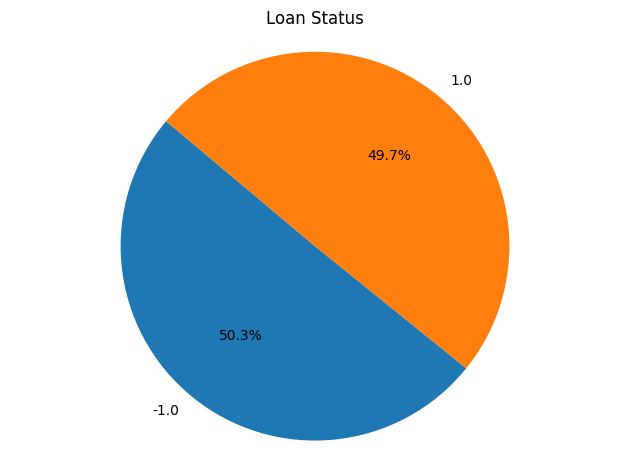

In [ ]:
from matplotlib import pyplot as plt
class_counts = train['loan_status'].value_counts()
plt.pie(class_counts, labels=class_counts.index, startangle=140, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Loan Status')
plt.tight_layout()
plt.show()

## Entropy 계산에서 Negative_data_train이 필요하여 추가된 부분.

In [ ]:
negative_data_train = train[train['loan_status'] == -1]
positive_data_train = train[train['loan_status'] == 1]
positive_data_train = positive_data_train.sample(frac=1 / 2, random_state=42)
negative_data_train = negative_data_train.sample(frac=1 / 2, random_state=42)
train = pd.concat([positive_data_train, negative_data_train], axis=0)
print(train.shape)

negative_data_val = val[val['loan_status'] == -1]
positive_data_val = val[val['loan_status'] == 1]
positive_data_val = positive_data_val.sample(frac=1 / 2, random_state=42)
negative_data_val = negative_data_val.sample(frac=1 / 2, random_state=42)
val = pd.concat([positive_data_val, negative_data_val], axis=0)
print(val.shape)

(2500, 20)
(2000, 20)


# Train 연속형변수 분포저장

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train =train.drop(columns='loan_status')
y_train =train['loan_status']

X_val =val.drop(columns='loan_status')
y_val = val['loan_status']

In [ ]:
def standard_scale_train(train_data, feature_names):
    """
    특정 feature들에 대해 Z 정규화를 수행하는 함수, sklearn의 StandardScaler 사용
    :param train_data: 훈련 데이터셋 (DataFrame)
    :param feature_names: 정규화를 수행할 특성들의 리스트
    :return: 정규화된 훈련 데이터셋, 훈련된 StandardScaler 객체
    """
    scaler = StandardScaler()
    train_data_scaled = train_data.copy()
    train_data_scaled[feature_names] = scaler.fit_transform(train_data[feature_names])
    return train_data_scaled, scaler


def standard_scale_val(X_val, feature_names, scaler):
    """
    validation set을 특정 feature들에 대해 Z 정규화하는 함수, sklearn의 StandardScaler 사용
    :param X_val: validation set (DataFrame)
    :param feature_names: 정규화를 수행할 특성들의 리스트
    :param scaler: 훈련 데이터셋에 대해 훈련된 StandardScaler 객체
    :return: 정규화된 validation set
    """
    X_val_scaled = X_val.copy()
    X_val_scaled[feature_names] = scaler.transform(X_val[feature_names])
    return X_val_scaled

In [ ]:
# # 위 block에서 만들어진 z_normalize와 z_normalize_val 적용 (Error 날 경우 다시 고민할 것)
X_train_norm = X_train.copy()
X_train_norm.loc[:, continuous_list], scaler = standard_scale_train(X_train, continuous_list )
X_val_norm = X_val.copy()
X_val_norm.loc[:, continuous_list] = standard_scale_val(X_val, continuous_list, scaler)

# SVM

In [ ]:
import numpy as np
import pandas as pd
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers

In [ ]:
# You could use the following function to calculate the entropy
from scipy.stats import entropy

# You can use the following function to calculate the Euclidean distance (distance.cdist)
from scipy.spatial import distance

In [ ]:
def Kernel_(x, y, params=0, type_='default'):
    if type_ == 'rbf':
        Kernel = np.exp(
            - (np.sum(x ** 2, axis=1).reshape(-1, 1) + np.sum(y ** 2, axis=1).reshape(1, -1) - 2 * x @ y.T) * params)
        return Kernel
    elif type_ == 'default':
        Kernel = np.dot(x, y.T)
        return Kernel


def Minmax_(X):
    return (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)), X.max(axis=0), X.min(axis=0)


def Standar_(X):
    return (X - X.mean(axis=0)) / X.std(axis=0), X.mean(axis=0), X.std(axis=0)


def Convolution(pred, real):
    pred = np.array(pred)
    y = np.array(real)
    TP = np.sum((pred == 1) & (y == 1))
    FP = np.sum((pred == 1) & (y != 1))
    FN = np.sum((pred != 1) & (y == 1))
    TN = np.sum((pred != 1) & (y != 1))
    return TP, FP, FN, TN


############## Accuracy is newly included!
def acc_precision_recall(X):
    TP, FP, FN, TN = X
    return (TP + TN) / (TP + FP + FN + TN), TP / (TP + FP), TP / (TP + FN)

In [ ]:
def get_pk(y, k_nearest_indicies):
    lst = y[k_nearest_indicies]
    unique, counts = np.unique(lst, return_counts=True)
    p_dict = dict(zip(unique, counts))
    try:
        p_pos = p_dict[1]
    except KeyError:
        p_pos = 0
    try:
        p_neg = p_dict[-1]
    except KeyError:
        p_neg = 0
    return [p_pos/k, p_neg/k]

In [ ]:
# Hyperparameter
C = 10
Gamma = 2
k = 7  # Number of Nearest Neighbor
M = 10
beta = 0.025

## Si_value 구하기

In [ ]:
#################################################################################
# TODO: Generate s_i !!!!!
# 1. Euclidean distance 계산
# 2. Negative class에 대한 Entropy 계산 (k=7 사용)
# 3. m = 10 / beta = 1/18을 사용하여 Entropy-based Fuzzy Membership 계산
# 4. Positive와 Negative class 모두에 대해 si 부여
#################################################################################

X = X_train_norm
y = y_train

distances = distance.cdist(X, X, 'euclidean')  # 모든 포인트 간의 거리 계산
distances_df = pd.DataFrame(data=distances, index=train.index, columns=train.index)

nearest_points = {}
for index, row in distances_df.iterrows():
    # 가장 가까운 k개의 점의 인덱스 찾기 (자기 자신 제외)
    nearest_indices = row.argsort()[1:k+1]
    # 해당 점들의 컬럼 이름 저장
    nearest_points[index] = list(distances_df.columns[nearest_indices])

Entropy_df=pd.DataFrame(columns=['Entropy'])
for key, value in nearest_points.items():
    Entropy_df.loc[key]=entropy(get_pk(y, value))

    # Entropy 계산 제대로 됐나 확인함.
    # print(f'Key: {key}')
    # print(get_pk(y, value))
    # print(y.loc[value])

# Negative Sample에 대해서만 membership이 구성되야 함.
memberships = [[] for _ in range(M)]
H_min = Entropy_df.loc[negative_data_train.index].min().values[0]
H_max = Entropy_df.loc[negative_data_train.index].max().values[0]

for l in range(1, M + 1):
    thrup = H_min + l * (H_max - H_min) / M
    thrlow = H_min + (l - 1) * (H_max - H_min) / M

    for idx in negative_data_train.index:
        entropy_value = Entropy_df.loc[idx].values[0]
        if thrlow <= entropy_value <= thrup:
            memberships[l - 1].append(idx)

# one_list = [item for sublist in memberships for item in sublist]
# len(one_list)

for l, sub_list in enumerate(memberships):
    for j in Entropy_df.index:
        if j in sub_list:
            FM = float(1 - beta * l)
            Entropy_df.loc[j, 'FM'] = FM

# NaN값은 Positive Sample이기 때문에 1로 채움.
Entropy_df=Entropy_df.fillna(1)
test_df= pd.concat([Entropy_df, y], axis=1)
si_values = Entropy_df['FM'].values

## Fuzzy SVM linear Kernel

In [ ]:
#################################################################################
# TODO: 위 Linear Kernel SVM을 사용하여 Linear Kernel EFSVM 구현
#################################################################################

#################################################################################
# TODO: 위 Linear Kernel SVM을 사용하여 Linear Kernel EFSVM 구현
#################################################################################

###### Standardization Scaler + Linear

#Initializing values and computing H. Note the 1. to force to float type
X = X_train_norm.values
y = y_train.values

y = y.reshape(-1, 1)
m, n = X.shape

#Kernel 관련 정의 numpy array 형식으로 생성
H = Kernel_(X, X) * 1.
H *= y @ y.T
P = cvxopt_matrix(H)
q = cvxopt_matrix(-np.ones((m, 1)))
G = cvxopt_matrix(np.vstack((-np.eye(m), np.eye(m))))
h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m) * C* si_values )))
A = cvxopt_matrix(y.reshape(1, -1))
b = cvxopt_matrix(np.zeros(1))

#Run solver
sol = cvxopt_solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])

w = ((y * alphas).T @ X).reshape(-1, 1)
S = ((alphas > 1e-4) & (alphas < C - 1e-4)).flatten()
b = y[S] - np.sum(Kernel_(X, X[S], type_='default') * y * alphas, axis=0).reshape(-1, 1)

# print('Alphas = ', alphas[(alphas > 1e-4) & (alphas < C - 1e-4)])
print('')
print('w = ', w.flatten())
print('')
print('b = ', np.mean(b))
print('')
# print("support vector : ", np.array(range(m))[S])
print("support vector length : ", len(np.array(range(m))[S]))

linear_alphas=alphas
linear_b=b[0]

     pcost       dcost       gap    pres   dres
 0: -1.0452e+04 -2.8294e+05  8e+05  1e+00  4e-10
 1: -9.8140e+03 -1.6385e+05  2e+05  2e-01  5e-10
 2: -1.0134e+04 -4.8073e+04  4e+04  5e-12  5e-10
 3: -1.2161e+04 -2.2909e+04  1e+04  2e-12  5e-10
 4: -1.3683e+04 -2.0244e+04  7e+03  5e-12  6e-10
 5: -1.4156e+04 -1.9400e+04  5e+03  2e-12  6e-10
 6: -1.4850e+04 -1.8083e+04  3e+03  2e-12  6e-10
 7: -1.5349e+04 -1.7150e+04  2e+03  1e-12  6e-10
 8: -1.5702e+04 -1.6489e+04  8e+02  9e-12  7e-10
 9: -1.5906e+04 -1.6171e+04  3e+02  4e-12  7e-10
10: -1.5984e+04 -1.6057e+04  7e+01  2e-12  8e-10
11: -1.6007e+04 -1.6027e+04  2e+01  1e-12  8e-10
12: -1.6013e+04 -1.6020e+04  7e+00  2e-12  7e-10
13: -1.6015e+04 -1.6017e+04  2e+00  1e-11  7e-10
14: -1.6016e+04 -1.6016e+04  2e-01  2e-11  8e-10
15: -1.6016e+04 -1.6016e+04  3e-02  1e-11  8e-10
16: -1.6016e+04 -1.6016e+04  2e-03  8e-13  8e-10
Optimal solution found.

w =  [ 0.22771519  0.77120026 -0.0063861  -0.03218937  0.16887645 -0.28770719
 -0.31605139  0.

## Fuzzy SVM rbf Kernel

In [ ]:
#################################################################################
# TODO: 위 Gaussian (RBF) Kernel SVM을 사용하여 Gaussian (RBF) Kernel EFSVM 구현
#################################################################################

#################################################################################
# TODO: 위 Gaussian (RBF) Kernel SVM을 사용하여 Gaussian (RBF) Kernel EFSVM 구현
#################################################################################

###### Standardization Scaler + RBF

#Initializing values and computing H. Note the 1. to force to float type
X = X_train_norm.values
y = y_train.values

y = y.reshape(-1, 1)
m, n = X.shape

#Kernel 관련 정의 numpy array 형식으로 생성
H = Kernel_(X, X, params=Gamma, type_='rbf') * 1.
H *= y @ y.T
P = cvxopt_matrix(H)
q = cvxopt_matrix(-np.ones((m, 1)))
G = cvxopt_matrix(np.vstack((-np.eye(m), np.eye(m))))
h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m) * C * si_values)))
A = cvxopt_matrix(y.reshape(1, -1))
b = cvxopt_matrix(np.zeros(1))

#Run solver
sol = cvxopt_solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])

#Results
S = ((alphas > 1e-4) & (alphas < C - 1e-4)).flatten()
b = y[S] - np.sum(Kernel_(X, X[S], params=Gamma, type_='rbf') * y * alphas, axis=0).reshape(-1, 1)
# print('Alphas = ', alphas[(alphas > 1e-4) & (alphas < C - 1e-4)])
print('')
print('b = ', b[0])
print('')
# print("support vector : ", np.array(range(m))[S])
print("support vector length : ", len(np.array(range(m))[S]))

# 서포트 벡터 계산


rbf_alphas=alphas
rbf_b=b[0]

     pcost       dcost       gap    pres   dres
 0:  5.9111e+03 -7.3788e+04  8e+04  3e-12  4e-15
 1:  6.3676e+02 -7.4199e+03  8e+03  7e-12  2e-15
 2: -1.1426e+03 -2.1100e+03  1e+03  5e-12  7e-16
 3: -1.2346e+03 -1.2772e+03  4e+01  8e-13  2e-16
 4: -1.2349e+03 -1.2369e+03  2e+00  2e-13  1e-16
 5: -1.2349e+03 -1.2350e+03  7e-02  1e-12  1e-16
 6: -1.2349e+03 -1.2349e+03  1e-03  6e-13  1e-16
Optimal solution found.

b =  [-0.0180501]

support vector length :  2500


# Decision Tree Validation Benchmark

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *
dt_model = DecisionTreeClassifier(random_state = 42)
dt_model.fit(X_train_norm, y_train)
y_pred = dt_model.predict(X_val_norm)
accuracy = accuracy_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)

print("accuracy :", accuracy)
print("precision", precision)
print("recall :", recall)

confusion_matrix = confusion_matrix(y_val, y_pred)
print(confusion_matrix)

accuracy : 0.7645
precision 0.7589893100097181
recall : 0.7778884462151394
[[748 248]
 [223 781]]


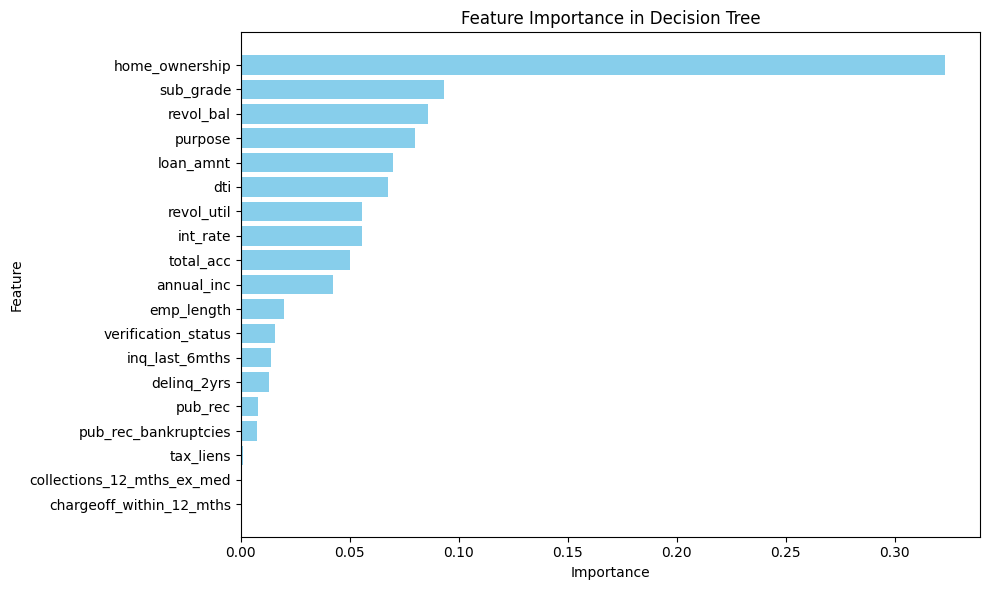

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

feature_importances = dt_model.feature_importances_

# 시각화를 위한 데이터프레임 생성
importance_df = pd.DataFrame({
    'Feature': X_train_norm.columns,
    'Importance': feature_importances
})

# 중요도 순으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Feature importance plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Decision Tree')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Validation 성능체크

In [ ]:
# Solution
pred_sol = np.sign(np.sum(Kernel_(X_val_norm.values, X_train_norm.values, type_ = 'default')@(y_train.values) * linear_alphas, axis=0).reshape(-1, 1) + linear_b).flatten()
acc_precision_recall(Convolution(pred_sol, y_val))

(0.5175, 0.5099135739705135, 0.999003984063745)

In [ ]:
# Solution
pred_sol2 = np.sign(np.sum(Kernel_(X_val_norm.values, X_train_norm.values, params=2, type_='rbf')@(y_train.values) * rbf_alphas, axis=0).reshape(-1, 1) + rbf_b).flatten()
acc_precision_recall(Convolution(pred_sol2, y_val))

(0.658, 0.7030456852791879, 0.5517928286852589)

In [ ]:
print('Linear EFSVM')
print(pred_sol[pred_sol==1.0].sum())
print(-1*pred_sol[pred_sol==-1.0].sum())
print(len(pred_sol)-len(y_val.values))
print('RBF EFSVM')
print(pred_sol2[pred_sol2==1.0].sum())
print(-1*pred_sol2[pred_sol2==-1.0].sum())
print(len(pred_sol2)-len(y_val.values))

Linear EFSVM
1967.0
33.0
0
RBF EFSVM
788.0
1212.0
0


## 3. System Implementation
- df_test에 기반하여 실제 사용을 위한 system implemetation 작업 진행
- Performance에 대한 평가데이터는 df_test로 지난 프로젝트와 마찬가지로 Data Pre-processing이 System implementation에 동시 구현
- 특히, scaler를 사용할 경우 cache를 반드시 사용하여 올바른 system implementation이 되도록 할 것!!! (주의!!!)

# Test 결측치처리

In [ ]:
delete_col = ['funded_amnt', 'funded_amnt_inv', 'installment', 'grade', 'open_acc', 'initial_list_status', 'recoveries',
              'collection_recovery_fee', 'acc_now_delinq', 'delinq_amnt', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',	'total_rec_int',	'total_rec_late_fee', 'last_pymnt_amnt']
df_1=df_test.copy()
df_1 = df_1.drop(columns=delete_col)

In [ ]:
df_1['collections_12_mths_ex_med']=df_1['collections_12_mths_ex_med'].replace(np.nan, df_1['collections_12_mths_ex_med'].median())
df_1['chargeoff_within_12_mths']=df_1['chargeoff_within_12_mths'].replace( np.nan, df_1['chargeoff_within_12_mths'].median())
df_1['pub_rec_bankruptcies']=df_1['pub_rec_bankruptcies'].replace(np.nan, df_1['pub_rec_bankruptcies'].median())
df_1['tax_liens']=df_1['tax_liens'].replace(np.nan, df_1['tax_liens'].median())
df_1['revol_util']=df_1['revol_util'].replace(np.nan, df_1['revol_util'].median())
# NaN 값을 '10+ years'로 대체
df_1['emp_length'].fillna('10+ years', inplace=True)

# Test 이상치제거

In [ ]:
df_2=df_1.copy()
df_2 = df_2[df_2['revol_util'] < 1.00]
df_2 = df_2[df_2['home_ownership'].isin(['MORTGAGE', 'OTHER', 'OWN', 'RENT'])]

# Test 범주형 인코딩

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

df_3 = df_2.copy()
df_3.reset_index(drop=True, inplace=True)

selected_list=['emp_length', 'verification_status']

for column in selected_list:
    le=label_encoders[column]
    df_3[column] = [label if label in le.classes_ else 'unknown' for label in df_3[column]]
    le.classes_ = np.append(le.classes_, 'unknown')  # 'unknown' 레이블 추가
    df_3[column] = le.transform(df_3[column])

mapping = {
    "Fully Paid": -1.0,
    "Charged Off": 1.0
}

# 매핑 적용
df_3['loan_status'] = df_3['loan_status'].map(mapping)

In [ ]:
df_3['purpose'] = encoder_1.transform(df_3[['purpose']])
df_3['home_ownership'] = encoder_2.transform(df_3[['home_ownership']])
df_3['sub_grade']=encoder_3.transform(df_3[['sub_grade']])

# Test 이산형변수 통일

In [ ]:
X2 = df_3.drop(columns=['loan_status'])
Y2 = df_3['loan_status']

# train에만 있고 test에 없는 경우, 해당 column name으로 test에 zero columns 추가.
X2[list(X_val_norm.columns[X_val_norm.columns.isin(X2) == False])] = 0

# test에만 있고 train에는 없는 경우, 해당 column name은 제거.
X2 = X2.drop(columns=list(X2.columns[X2.columns.isin(X_val_norm) == False]))
X2 = X2[X_val_norm.columns]

# Test 연속형변수 통일

In [ ]:
# 가지고 있는 cache로 df_test normalize
X2.loc[:, continuous_list] = standard_scale_val(X2, continuous_list, scaler)

# Test 성능체크

In [ ]:
y_pred = dt_model.predict(X2)
accuracy = accuracy_score(Y2, y_pred)
recall = recall_score(Y2, y_pred)
precision = precision_score(Y2, y_pred)

print("accuracy :", accuracy)
print("precision", precision)
print("recall :", recall)

accuracy : 0.699
precision 0.15587044534412955
recall : 0.29389312977099236


In [ ]:
# Solution
pred_sol = np.sign(np.sum(Kernel_(X2.values, X_train_norm.values  ,type_ = 'default')@ (y_train.values) * linear_alphas , axis = 0).reshape(-1,1) + linear_b).flatten()
acc_precision_recall(Convolution(pred_sol,Y2.values))

(0.1655, 0.13530326594090203, 0.9961832061068703)

In [ ]:
# Solution
pred_sol2 = np.sign(np.sum(Kernel_(X2.values, X_train_norm.values, params=1, type_='rbf')@(y_train.values) * rbf_alphas, axis=0).reshape(-1, 1) + rbf_b).flatten()
acc_precision_recall(Convolution(pred_sol2, Y2.values))

(0.616, 0.15437158469945356, 0.4312977099236641)

In [ ]:
print('Linear EFSVM')
print(pred_sol[pred_sol==1.0].sum())
print(-1*pred_sol[pred_sol==-1.0].sum())
print(len(pred_sol)-len(Y2.values))
print('RBF EFSVM')
print(pred_sol2[pred_sol2==1.0].sum())
print(-1*pred_sol2[pred_sol2==-1.0].sum())
print(len(pred_sol2)-len(Y2.values))

Linear EFSVM
1929.0
71.0
0
RBF EFSVM
732.0
1268.0
0


# APPENDIX: EFSVM Tuning

In [ ]:
#################################################################################
# TODO: 위 Linear Kernel SVM을 사용하여 Linear Kernel EFSVM 구현
#################################################################################

###### Standardization Scaler + Linear

#Initializing values and computing H. Note the 1. to force to float type
X = X_train_norm.values
y = y_train.values

y = y.reshape(-1, 1)
m, n = X.shape


def EFSVM_linear(C, si_values):
    #Kernel 관련 정의 numpy array 형식으로 생성
    H = Kernel_(X, X) * 1.
    H *= y @ y.T
    P = cvxopt_matrix(H)
    q = cvxopt_matrix(-np.ones((m, 1)))
    G = cvxopt_matrix(np.vstack((-np.eye(m), np.eye(m))))
    h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m) * C* si_values )))
    A = cvxopt_matrix(y.reshape(1, -1))
    b = cvxopt_matrix(np.zeros(1))

    #Run solver
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])

    w = ((y * alphas).T @ X).reshape(-1, 1)
    S = ((alphas > 1e-4) & (alphas < C - 1e-4)).flatten()
    b = y[S] - np.sum(Kernel_(X, X[S], type_='default') * y * alphas, axis=0).reshape(-1, 1)

    # print('Alphas = ', alphas[(alphas > 1e-4) & (alphas < C - 1e-4)])
    print('')
    print('w = ', w.flatten())
    print('')
    print('b = ', np.mean(b))
    print('')
    # print("support vector : ", np.array(range(m))[S])
    print("support vector length : ", len(np.array(range(m))[S]))

    linear_alphas=alphas
    linear_b=b[0]

    return linear_alphas, linear_b


def EFSVM_rbf(C, gamma, si_values) :
    #Kernel 관련 정의 numpy array 형식으로 생성
    H = Kernel_(X, X) * 1.
    H *= y @ y.T
    P = cvxopt_matrix(H)
    q = cvxopt_matrix(-np.ones((m, 1)))
    G = cvxopt_matrix(np.vstack((-np.eye(m), np.eye(m))))
    h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m) * C * si_values )))
    A = cvxopt_matrix(y.reshape(1, -1))
    b = cvxopt_matrix(np.zeros(1))

    #Run solver
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])

    w = ((y * alphas).T @ X).reshape(-1, 1)
    S = ((alphas > 1e-4) & (alphas < C - 1e-4)).flatten()
    b = y[S] - np.sum(Kernel_(X, X[S], params=Gamma, type_='rbf') * y * alphas, axis=0).reshape(-1, 1)

    # print('Alphas = ', alphas[(alphas > 1e-4) & (alphas < C - 1e-4)])
    print('')
    print('w = ', w.flatten())
    print('')
    print('b = ', np.mean(b))
    print('')
    # print("support vector : ", np.array(range(m))[S])
    print("support vector length : ", len(np.array(range(m))[S]))

    rbf_alphas=alphas
    rbf_b=b[0]

    return rbf_alphas, rbf_b

In [ ]:
#################################################################################
# TODO: Generate s_i !!!!!
# 1. Euclidean distance 계산
# 2. Negative class에 대한 Entropy 계산 (k=7 사용)
# 3. m = 10 / beta = 1/18을 사용하여 Entropy-based Fuzzy Membership 계산
# 4. Positive와 Negative class 모두에 대해 si 부여
#################################################################################

def entropy_cal(M, beta):
    distances = distance.cdist(X_train_norm, X_train_norm, 'euclidean')  # 모든 포인트 간의 거리 계산
    distances_df = pd.DataFrame(data=distances, index=train.index, columns=train.index)

    nearest_points = {}
    for index, row in distances_df.iterrows():
        # 가장 가까운 7개의 점의 인덱스 찾기 (자기 자신 제외)
        nearest_indices = row.argsort()[1:8]
        # 해당 점들의 컬럼 이름 저장
        nearest_points[index] = list(distances_df.columns[nearest_indices])

    Entropy_df=pd.DataFrame(columns=['Entropy'])
    for key, value in nearest_points.items():
        Entropy_df.loc[key]=entropy(get_pk(y_train, value))

        # Entropy 계산 제대로 됐나 확인함.
        # print(f'Key: {key}')
        # print(get_pk(y, value))
        # print(y.loc[value])

    # Negative Sample에 대해서만 membership이 구성되야 함.
    memberships = [[] for _ in range(M)]
    H_min = Entropy_df.loc[negative_data_train.index].min().values[0]
    H_max = Entropy_df.loc[negative_data_train.index].max().values[0]

    for l in range(1, M + 1):
        thrup = H_min + l * (H_max - H_min) / M
        thrlow = H_min + (l - 1) * (H_max - H_min) / M

        for idx in negative_data_train.index:
            entropy_value = Entropy_df.loc[idx].values[0]
            if thrlow <= entropy_value <= thrup:
                memberships[l - 1].append(idx)

    # one_list = [item for sublist in memberships for item in sublist]
    # len(one_list)

    for l, sub_list in enumerate(memberships):
        for j in Entropy_df.index:
            if j in sub_list:
                FM = float(1 - beta * l)
                Entropy_df.loc[j, 'FM'] = FM

    # NaN값은 Positive Sample이기 때문에 1로 채움.
    Entropy_df=Entropy_df.fillna(1)
    test_df= pd.concat([Entropy_df, y_train], axis=1)
    si_values = Entropy_df['FM'].values

    return si_values

loan_status 예측에는 Precision이 중요.

In [ ]:
# Solution
def evaluation(linear_alphas, linear_b, kernel, gamma=0):
    if kernel == 'linear':
      pred_sol = np.sign(np.sum(Kernel_(X_val_norm.values, X_train_norm.values, type_ = 'default') @ (y_train.values) * (linear_alphas) , axis = 0).reshape(-1,1) + linear_b).flatten()
    if kernel == 'rbf':
      pred_sol = np.sign(np.sum(Kernel_(X_val_norm.values, X_train_norm.values, params=gamma, type_ = 'rbf') @ (y_train.values) * linear_alphas , axis = 0).reshape(-1,1) + linear_b).flatten()

    eval = f1_score(y_val, pred_sol.reshape(-1), average='weighted')

    if eval == np.nan:
      eval=0.0
      print('nan')
    return eval

In [ ]:
# Define the parameter grid
C_values = [0.1, 1, 10]
gamma = [2,0.01]
M_values = [5, 10]

# Initialize variables to store the best results
best_score = -1
best_hyperparameters = None
best_b=None
best_alpha=None

kernel='rbf'

# Perform grid search
for M in M_values:
  beta_values = [1/(4*M),1/(5*M), 1/(10*M)]
  for beta in beta_values:
    si_values = entropy_cal(M, beta)
    for C in C_values:

        if kernel=='linear':
            alphas, b = EFSVM_linear(C, si_values)
            eval = evaluation(alphas, b, kernel)
            score = eval
            print('C:', C, 'M:', M, 'beta:', beta)

            if score > best_score:
              best_b=b[0]
              best_alpha=alphas
              best_score = score
              best_hyperparameters = {'C': C, 'M': M, 'beta': beta}
              print("best score is : ", best_score)

        elif kernel=='rbf':
          for g in gamma:
            alphas, b = EFSVM_rbf(C, g, si_values)
            eval = evaluation(alphas, b, kernel, g)
            score = eval
            print('C:', C, 'gamma:', g, 'M:', M, 'beta:', beta)

            # Append score and check if it's the best
            if score > best_score:
                best_b=b[0]
                best_alpha=alphas
                best_score = score
                best_hyperparameters = {'C': C, 'gamma': g, 'M': M, 'beta': beta}
                print("best score is : ", best_score)

# Output the best hyperparameters
print("Best Hyperparameters for EFSVM: ", best_hyperparameters)
print("Best Score: ", best_score)

     pcost       dcost       gap    pres   dres
 0: -1.0452e+04 -2.8294e+05  8e+05  1e+00  4e-10
 1: -9.8140e+03 -1.6385e+05  2e+05  2e-01  5e-10
 2: -1.0134e+04 -4.8073e+04  4e+04  5e-12  5e-10
 3: -1.2161e+04 -2.2909e+04  1e+04  2e-12  5e-10
 4: -1.3683e+04 -2.0244e+04  7e+03  5e-12  6e-10
 5: -1.4156e+04 -1.9400e+04  5e+03  2e-12  6e-10
 6: -1.4850e+04 -1.8083e+04  3e+03  2e-12  6e-10
 7: -1.5349e+04 -1.7150e+04  2e+03  1e-12  6e-10
 8: -1.5702e+04 -1.6489e+04  8e+02  9e-12  7e-10
 9: -1.5906e+04 -1.6171e+04  3e+02  4e-12  7e-10
10: -1.5984e+04 -1.6057e+04  7e+01  2e-12  8e-10
11: -1.6007e+04 -1.6027e+04  2e+01  1e-12  8e-10
12: -1.6013e+04 -1.6020e+04  7e+00  2e-12  7e-10
13: -1.6015e+04 -1.6017e+04  2e+00  1e-11  7e-10
14: -1.6016e+04 -1.6016e+04  2e-01  2e-11  8e-10
15: -1.6016e+04 -1.6016e+04  3e-02  1e-11  8e-10
16: -1.6016e+04 -1.6016e+04  2e-03  8e-13  8e-10
Optimal solution found.

w =  [ 0.22771519  0.77120026 -0.0063861  -0.03218937  0.16887645 -0.28770719
 -0.31605139  0.

In [ ]:
# Solution
if kernel == 'linear':
    pred_sol = np.sign(np.sum(Kernel_(X2.values, X_train_norm.values, type_='default')@(y_train.values) * best_alpha , axis = 0).reshape(-1,1) + best_b).flatten()

# Solution
if kernel == 'rbf':
    pred_sol = np.sign(np.sum(Kernel_(X2.values, X_train_norm.values  ,params=Gamma, type_='rbf')@(y_train.values) * best_alpha , axis = 0).reshape(-1,1) + best_b).flatten()

acc_precision_recall(Convolution(pred_sol,Y2.values))

(0.157199, 0.131, 0.9645)

# APPENDIX: Soft SVM Tuning

In [ ]:
#################################################################################
# TODO: 위 Linear Kernel SVM을 사용하여 Linear Kernel EFSVM 구현
#################################################################################

###### Standardization Scaler + Linear

#Initializing values and computing H. Note the 1. to force to float type
X = X_train_norm.values
y = y_train.values

y = y.reshape(-1, 1)
m, n = X.shape


def SVM_linear(C):
    #Kernel 관련 정의 numpy array 형식으로 생성
    H = Kernel_(X, X) * 1.
    H *= y @ y.T
    P = cvxopt_matrix(H)
    q = cvxopt_matrix(-np.ones((m, 1)))
    G = cvxopt_matrix(np.vstack((-np.eye(m), np.eye(m))))
    h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m) * C )))
    A = cvxopt_matrix(y.reshape(1, -1))
    b = cvxopt_matrix(np.zeros(1))

    #Run solver
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])

    w = ((y * alphas).T @ X).reshape(-1, 1)
    S = ((alphas > 1e-4) & (alphas < C - 1e-4)).flatten()
    b = y[S] - np.sum(Kernel_(X, X[S], type_='default') * y * alphas, axis=0).reshape(-1, 1)

    # print('Alphas = ', alphas[(alphas > 1e-4) & (alphas < C - 1e-4)])
    print('')
    print('w = ', w.flatten())
    print('')
    print('b = ', np.mean(b))
    print('')
    # print("support vector : ", np.array(range(m))[S])
    print("support vector length : ", len(np.array(range(m))[S]))

    linear_alphas=alphas
    linear_b=b[0]

    return linear_alphas, linear_b


def SVM_rbf(C, gamma) :
    #Kernel 관련 정의 numpy array 형식으로 생성
    H = Kernel_(X, X) * 1.
    H *= y @ y.T
    P = cvxopt_matrix(H)
    q = cvxopt_matrix(-np.ones((m, 1)))
    G = cvxopt_matrix(np.vstack((-np.eye(m), np.eye(m))))
    h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m) * C )))
    A = cvxopt_matrix(y.reshape(1, -1))
    b = cvxopt_matrix(np.zeros(1))

    #Run solver
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])

    w = ((y * alphas).T @ X).reshape(-1, 1)
    S = ((alphas > 1e-4) & (alphas < C - 1e-4)).flatten()
    b = y[S] - np.sum(Kernel_(X, X[S], params=Gamma, type_='rbf') * y * alphas, axis=0).reshape(-1, 1)

    # print('Alphas = ', alphas[(alphas > 1e-4) & (alphas < C - 1e-4)])
    print('')
    print('w = ', w.flatten())
    print('')
    print('b = ', np.mean(b))
    print('')
    # print("support vector : ", np.array(range(m))[S])
    print("support vector length : ", len(np.array(range(m))[S]))

    rbf_alphas=alphas
    rbf_b=b[0]

    return rbf_alphas, rbf_b

In [ ]:
# Define the parameter grid
C_values = [10, 1, 0.1]
gamma = [2,0.01]

# Initialize variables to store the best results
best_score = -1  # Start with a very low score
best_hyperparameters = None
best_b=None
best_alpha=None

kernel='linear'

# Perform grid search

for C in C_values:
    if kernel=='linear':
        alphas, b = SVM_linear(C)
        eval = evaluation(alphas, b, kernel)
        score = eval
        print('C:', C)

        if score > best_score:
          best_b=b[0]
          best_alpha=alphas
          best_score = score
          best_hyperparameters = {'C': C}
          print("best score is : ", best_score)

    elif kernel=='rbf':
      for g in gamma:
        alphas, b = SVM_rbf(C, g)
        eval = evaluation(alphas, b, kernel, g)
        score = eval
        print('C:', C, 'gamma:', g)

        # Append score and check if it's the best
        if score > best_score:
            best_b=b[0]
            best_alpha=alphas
            best_score = score
            best_hyperparameters = {'C': C, 'gamma': g}
            print("best score is : ", best_score)

# Output the best hyperparameters
print("Best Hyperparameters for EFSVM: ", best_hyperparameters)
print("Best Score: ", best_score)

     pcost       dcost       gap    pres   dres
 0: -1.1398e+04 -3.4671e+05  1e+06  1e+00  4e-10
 1: -1.0818e+04 -2.0035e+05  2e+05  2e-01  5e-10
 2: -1.1180e+04 -5.6977e+04  5e+04  3e-03  6e-10
 3: -1.3442e+04 -2.5286e+04  1e+04  8e-04  6e-10
 4: -1.5378e+04 -2.2489e+04  7e+03  3e-04  7e-10
 5: -1.6344e+04 -2.0858e+04  5e+03  2e-04  7e-10
 6: -1.6932e+04 -1.9716e+04  3e+03  6e-05  7e-10
 7: -1.7315e+04 -1.8977e+04  2e+03  4e-05  7e-10
 8: -1.7654e+04 -1.8360e+04  7e+02  1e-05  8e-10
 9: -1.7849e+04 -1.8034e+04  2e+02  3e-06  8e-10
10: -1.7898e+04 -1.7959e+04  6e+01  7e-07  8e-10
11: -1.7917e+04 -1.7933e+04  2e+01  1e-07  8e-10
12: -1.7922e+04 -1.7926e+04  4e+00  3e-08  8e-10
13: -1.7923e+04 -1.7925e+04  2e+00  1e-08  8e-10
14: -1.7924e+04 -1.7924e+04  3e-01  2e-09  9e-10
15: -1.7924e+04 -1.7924e+04  3e-03  2e-11  1e-09
Optimal solution found.

w =  [ 0.2448328   0.58382054  0.02589048 -0.0334089   0.1545064  -0.24864685
 -0.35025238  0.01013539  0.17689674 -0.35818412 -0.25306831 -1.7

In [ ]:
# Solution
if kernel == 'linear':
    pred_sol = np.sign(np.sum(Kernel_(X2.values, X_train_norm.values, type_='default')@(y_train.values) * best_alpha , axis = 0).reshape(-1,1) + best_b).flatten()

# Solution
if kernel == 'rbf':
    pred_sol = np.sign(np.sum(Kernel_(X2.values, X_train_norm.values  ,params=Gamma, type_='rbf')@(y_train.values) * best_alpha , axis = 0).reshape(-1,1) + best_b).flatten()

acc_precision_recall(Convolution(pred_sol,Y2.values))

(0.157199, 0.131, 0.9645)